In [1]:
import sys
sys.path.append('../utils/')

from utils import *
# from TableMapper import TableMapper

from tqdm.notebook import tqdm
tqdm.pandas()

In [60]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers = 7)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [280]:
import re

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

import spacy
nlp = spacy.load("en_core_web_sm")

import pandas as pd

class TableMapper():
    
    def __init__(self, query, schema):
        self.query = query
        self.schema = schema
        self.stemmer = PorterStemmer()

        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.stop_words.add('number')
      
    
    def get_filtered_schema(self, schema_id):
        '''
        Returns the filtered schema and query df for a given schema_id
        EX: get all queries and table details for 'college_2'
        '''
        s = self.schema[self.schema.schema_id == schema_id].reset_index(drop = True)
        t = self.query[self.query.db_id == schema_id].reset_index(drop = True)
        
        return s, t
    
    def get_wordnet_pos(self, treebank_tag):
        '''
        Map treebank part-of-speech tags to WordNet part-of-speech tags
        '''
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN  # Default to noun
    
    def remove_stopwords(self, sentence):    
        '''
        Remove all stopwords from a TQL query
        '''
        words = word_tokenize(sentence)
        pos_tags = nltk.pos_tag(words)
        lemmatized_words = [self.lemmatizer.lemmatize(word, self.get_wordnet_pos(pos)) \
                            for word, pos in pos_tags if not word.lower() in self.stop_words]
        # stemmed_words = [self.stemmer.stem(w) \
        #                     for w in words if not w.lower() in self.stop_words]
        
        lemmatized = ' '.join(lemmatized_words)
        # stemmed = ' '.join(stemmed_words)
        
        return re.sub('[^a-zA-Z ]', '', (lemmatized)).split()
    
    
    def get_column_list_from_row(self, filtered_schema_row):
        '''
        Get all column names in a schema row
        Appends table name in the column_list as well
        '''
        table_name_in_row_original = filtered_schema_row.table_name_original
        table_name_in_row = filtered_schema_row.table_name_original
        col_list = re.sub('\'', '', filtered_schema_row.column_list[1:-1]).split(', ')
        col_list.append(table_name_in_row)
        col_list.append(table_name_in_row_original)
        
        return col_list
    
    def get_scores(self, query, column_list_full):
        '''
        Get score based on number of words that are in query and the (colum list + table_name) list
        '''
        scores = []
        for column_list in column_list_full:
            score = 0
            for word in query:
                for column in column_list:
                    col = self.lemmatizer.lemmatize(column, wordnet.NOUN)
                    col1 = self.stemmer.stem(column, wordnet.NOUN)
                    if(word.startswith(col) or word.endswith(col)
                       or col.startswith(word) or col.endswith(word)): 
                       #  word.startswith(col1) or word.endswith(col1)
                       # or col1.startswith(word) or col1.endswith(word)):
                        score += 1    
            if(score > 0):
                scores.append([query, column_list, score])

        scores_df = pd.DataFrame(scores, columns = ['query_words', 'col_list', 'score'])\
                    .sort_values(by = 'score', ascending = False)\
                    .reset_index(drop = True)
        # display(scores_df)
        return scores_df
    
    def get_column_overlap_score(self, scores):
        '''
        Second iteration of scores dataframe to reduce the impact of ordering in table.
        Takes in the scores dataframe and iterates through it and removes the words from query already matched.
        '''
        final = []
        for column_list, query in zip(scores.col_list.to_list(), scores.query_words.to_list()):
            score_temp = 0
            for word in query[:]:
                for column in column_list[:]:
                    col = self.lemmatizer.lemmatize(column, wordnet.NOUN)
                    col1 = self.stemmer.stem(column, wordnet.NOUN)
                    if(word.startswith(col) or word.endswith(col)
                       or col.startswith(word) or col.endswith(word)): # or
                       #  word.startswith(col1) or word.endswith(col1)
                       # or col1.startswith(word) or col1.endswith(word)):
                        score_temp += 1
                        query.remove(word)
                        break
                        break

            if(score_temp > 0):
                final.append([column_list, query, score_temp])
                
        # display(pd.DataFrame(final))

        return final 
    
    def get_synonyms_wordnet(self, word):
        synonyms = []
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonyms.append(lemma.name())
        return synonyms
    
    def get_synonyms(self, query):
        
        query_list = query.split()
        for i in query_list:
            synonyms = self.get_synonyms_wordnet(i)
            if synonyms:
                synonyms = list(set(synonyms))
                for synonym in synonyms:
                    query += (' ' + synonym.replace('_', ' '))
        
        return query
            
    
    def get_replace_ner(self, query):
        
        doc = nlp(query)
        for ent in doc.ents:
            query = query.replace(ent.text, spacy.explain(ent.label_))    
        
        query = re.sub('[^a-zA-Z ]', '', query.lower())
        query = self.get_synonyms(query)
        
        return query
        
    
    def get_table_names_tql(self, s, query, verbosity):
        '''
        returns table names extracted from the TQL mapped with the schema details
        '''
        
        query = self.get_replace_ner(query)
        stop_words_query = self.remove_stopwords(query)
        if(verbosity == 1):
            print(stop_words_query)
        
        # for each table gets the column_list for table in filtered schema dataframe
        col_list = s.apply(lambda x : self.get_column_list_from_row(x), axis = 1).to_list()
        
        # get first iteration of scores
        score = self.get_scores(stop_words_query, col_list)
        # second iteration for scores that removes query words afer matching
        over_lap_score = self.get_column_overlap_score(score)

        # Extracting table names from matched column_list
        table_names_mapping = []
        for j in over_lap_score:
            table_names_mapping.append(j[0][-1])
            
        return table_names_mapping
        
    
    def get_exact_match_accuracy(self, s, t, verbosity = 0):
        '''
        Take in the filtered tables of query and schema and returns the percentage of exact match columns
        '''
        count = 0

        # for each query
        for i in range(len(t)):
                
            table_names_mapping = [k.lower() for k in self.get_table_names_tql(s, t.TQL.iloc[i], verbosity)]

            # Getting actual table names from the SQL query
            sql_tokens = [
                            token for token in re.sub('[^a-zA-Z_.0-9 ]', '', t.SQL.iloc[i]).lower().split() \
                            if ((token not in self.stop_words) and len(token) > 2)
                         ]
            actual_list = []
            for token in sql_tokens:
                for table_name in s.table_name_original.values:
                    if(token == table_name.lower()):
                        actual_list.append(token.lower())
            # print(actual_list)
            # break
            # If we want to check subset, uncomment this if-else 
            # if(not set(actual_list).issubset(set(table_names_mapping))):
            if(list(set(actual_list)) != list(set(table_names_mapping))):
                if(verbosity == 1):
                    print(t.TQL.iloc[i])
                    print(t.SQL.iloc[i])
                    print(self.remove_stopwords(t.TQL.iloc[i]))
                    print('----------------------------------------------------------------------------')
                    print('Actual List', actual_list, '| Predicted List', table_names_mapping, i)
                    print('----------------------------------------------------------------------------')
                
                else:
                    continue
            else:
                count += 1

        return count, len(t)

In [281]:
query, schema = get_spider_schema_table_files()
tableMapper = TableMapper(query, schema)

In [282]:
res = []
count1 = 0
count2 = 0
def get_counts(schemas):
    count1 = 0
    count2 = 0
    i = schemas
    s, t = tableMapper.get_filtered_schema(i)
    count_match, count_all = tableMapper.get_exact_match_accuracy(s, t)
    count1 += count_match
    count2 += count_all
    if(count1 == 0):
        print(i)

    res = [i, count_match/count_all, len(s), len(t)]
    
    return count1, count2, res

In [ ]:
%%time
count_df = pd.Series(list(set(schema.schema_id.values))).\
    rename({0 : 'schemas'}).\
    parallel_apply(get_counts)

hospital_1


In [273]:
df_results = pd.DataFrame()
df_results[['count1', 'count2', 'res']] = pd.DataFrame(pd.DataFrame(count_df)[0].tolist())
df_results

,count1,count2,res
0,9,19,"[flight_company, 0.47368421052631576, 3, 19]"
1,49,82,"[wine_1, 0.5975609756097561, 3, 82]"
2,11,58,"[match_season, 0.1896551724137931, 4, 58]"
3,1,44,"[document_management, 0.022727272727272728, 9,..."
4,21,84,"[cre_Docs_and_Epenses, 0.25, 7, 84]"
...,...,...,...
169,2,15,"[customers_and_products_contacts, 0.1333333333..."
170,52,68,"[student_1, 0.7647058823529411, 2, 68]"
171,22,45,"[concert_singer, 0.4888888888888889, 4, 45]"
172,36,100,"[Pesticide, 0.36, 2, 100]"


In [274]:
test_schema = 'restaurants'
s, t = tableMapper.get_filtered_schema(test_schema)
count_match, count_all = tableMapper.get_exact_match_accuracy(s, t, 0)
print(count_match / count_all)
# print(tableMapper.get_exact_match_accuracy(t, s, verbosity=1))

0.472


In [275]:
s

,schema_id,table_name,table_name_original,primary_key,column_list,column_list_original,column_datatypes,foreign_keys
0,restaurants,geographic,GEOGRAPHIC,CITY_NAME,"['city name', 'county', 'region']","['CITY_NAME', 'COUNTY', 'REGION']","['text', 'text', 'text']","[['restaurant', 'CITY_NAME', 'geographic', 'CI..."
1,restaurants,restaurant,RESTAURANT,ID,"['id', 'name', 'food type', 'city name', 'rati...","['ID', 'NAME', 'FOOD_TYPE', 'CITY_NAME', 'RATI...","['number', 'text', 'text', 'text', 'number']",[]
2,restaurants,location,LOCATION,RESTAURANT_ID,"['restaurant id', 'house number', 'street name...","['RESTAURANT_ID', 'HOUSE_NUMBER', 'STREET_NAME...","['number', 'number', 'text', 'text']",[]


In [276]:
df_results['count1'].sum()
df_results['count2'].sum()

10229

In [277]:
df_results

,count1,count2,res
0,9,19,"[flight_company, 0.47368421052631576, 3, 19]"
1,49,82,"[wine_1, 0.5975609756097561, 3, 82]"
2,11,58,"[match_season, 0.1896551724137931, 4, 58]"
3,1,44,"[document_management, 0.022727272727272728, 9,..."
4,21,84,"[cre_Docs_and_Epenses, 0.25, 7, 84]"
...,...,...,...
169,2,15,"[customers_and_products_contacts, 0.1333333333..."
170,52,68,"[student_1, 0.7647058823529411, 2, 68]"
171,22,45,"[concert_singer, 0.4888888888888889, 4, 45]"
172,36,100,"[Pesticide, 0.36, 2, 100]"


0.3676875129835626
0.2990517157102356


,schema_id,score,num_tables,num_queries
0,coffee_shop,0.000000,4,18
1,baseball_1,0.000000,26,82
2,sakila_1,0.000000,16,82
3,assets_maintenance,0.000000,14,31
4,riding_club,0.000000,5,17
5,academic,0.005525,15,181
6,college_2,0.011834,11,169
7,formula_1,0.012658,13,79
8,college_3,0.013514,8,74
9,scholar,0.015817,10,569


<AxesSubplot:>

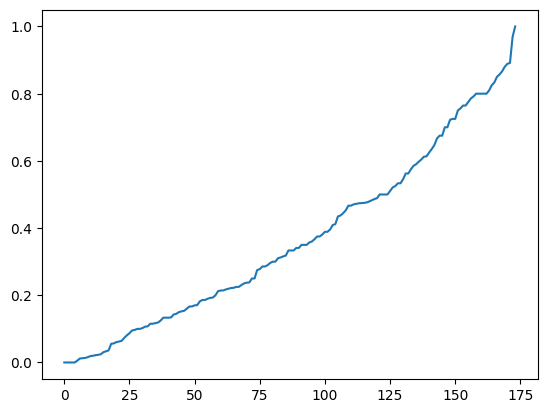

In [278]:
count1 = df_results['count1'].sum()
count2 = df_results['count2'].sum()
score_df = pd.DataFrame(df_results['res'].tolist(), 
                columns = ['schema_id', 'score', 'num_tables', 'num_queries']
            ).sort_values(by = 'score').reset_index(drop = True)
print(score_df.score.mean())
print(count1 / count2)
display(score_df.head(10))
score_df.score.plot()

In [279]:
print(count1)
print(count2)

# 5194
# 9685

# 5223
# 9685

3059
10229
